<a href="https://colab.research.google.com/github/trisha025/Image_Classification_TransferLearning/blob/master/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch
!pip3 install torchvision

In [0]:
import torch
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torchsummary import torchsummary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [0]:
image_transforms = {
    'train' : transforms.Compose([
                                  transforms.RandomResizedCrop(size=256, scale=(0.8,1.0)),
                                  transforms.RandomRotation(degrees=15),
                                  transforms.CenterCrop(size=224),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406],
                                                       [0.229, 0.224, 0.225])
    ]),
    'valid' : transforms.Compose([
                                  transforms.Resize(size=256),
                                  transforms.CenterCrop(size=224),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406],
                                                       [0.229, 0.224, 0.225])
    ]),
    'test' : transforms.Compose([
                                 transforms.Resize(size=256),
                                 transforms.CenterCrop(size=224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                      [0.229, 0.224, 0.225])
    ])
}

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
dataset = '/content/gdrive/My Drive/caltech/'
train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')
test_directory = os.path.join(dataset, 'test')

In [43]:
bs = 32
num_classes = len(os.listdir(valid_directory))-1
print(num_classes)

9


In [0]:
data = {
    'train' : datasets.ImageFolder(root=train_directory,
                                   transform=image_transforms['train']),
        'valid' : datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
        'test' : datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

In [45]:
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

{0: 'bear', 1: 'chimp', 2: 'giraffe', 3: 'gorilla', 4: 'llama', 5: 'ostrich', 6: 'porcupine', 7: 'skunk', 8: 'triceratops', 9: 'zebra'}


In [46]:
train_data_size = len(data['train'])
print(train_data_size)

600


In [47]:
valid_data_size = len(data['valid'])
print(valid_data_size)

100


In [48]:
test_data_size = len(data['test'])
print(test_data_size)

409


In [0]:
train_data = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data = DataLoader(data['test'], batch_size=bs, shuffle=True)

In [0]:
resnet50 = models.resnet50(pretrained=True)

In [0]:
for param in resnet50.parameters():
  param.requires_grad = False

In [0]:
fc_inputs = resnet50.fc.in_features

In [0]:
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10),
    nn.LogSoftmax(dim=1)
)

In [0]:
resnet50 = resnet50.to("cuda:0")

In [0]:
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

In [0]:
#training and validation
def train_and_validate(model, loss_criterion, optimizer, epochs = 25):
  start = time.time()
  history = []
  best_acc = 0.0

  for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))

    model.train()

    train_loss = 0.0
    train_acc = 0.0

    valid_loss = 0.0
    valid_acc = 0.0

    for i, (inputs, labels) in enumerate(train_data):

      inputs=inputs.to(device)
      labels=labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)

      loss = loss_criterion(outputs, labels)

      loss.backward()

      optimizer.step()

      train_loss += loss.item() * inputs.size(0)

      ret, predictions = torch.max(outputs.data, 1)
      correct_counts = predictions.eq(labels.data.view_as(predictions))

      acc = torch.mean(correct_counts.type(torch.FloatTensor))

      train_acc += acc.item() * inputs.size(0)

    with torch.no_grad():
      model.eval()

      for j, (inputs, labels) in enumerate(valid_data):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = loss_criterion(outputs, labels)

        valid_loss += loss.item() * inputs.size(0)

        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))

        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        
        valid_acc += acc.item() * inputs.size(0)

    
    avg_train_loss = train_loss/train_data_size
    avg_train_acc = train_acc/train_data_size

    avg_valid_loss = valid_loss/valid_data_size
    avg_valid_acc = valid_acc/valid_data_size

    history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

    epoch_end = time.time()

    print("Epoch :  {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start ))

    torch.save(model, dataset+'_model_' +str(epoch)+'.pt')

  return model, history

In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 30
trained_model, history = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'history.pt')

Epoch: 1/30
Epoch :  000, Training: Loss: 0.0430, Accuracy: 98.6667%, 
		Validation: Loss: 0.1718, Accuracy: 93.0000%, Time: 8.1443s
Epoch: 2/30
Epoch :  001, Training: Loss: 0.0535, Accuracy: 98.5000%, 
		Validation: Loss: 0.1803, Accuracy: 95.0000%, Time: 8.0818s
Epoch: 3/30
Epoch :  002, Training: Loss: 0.0460, Accuracy: 98.0000%, 
		Validation: Loss: 0.1389, Accuracy: 95.0000%, Time: 8.3281s
Epoch: 4/30
Epoch :  003, Training: Loss: 0.0281, Accuracy: 99.1667%, 
		Validation: Loss: 0.1893, Accuracy: 92.0000%, Time: 8.1536s
Epoch: 5/30
Epoch :  004, Training: Loss: 0.0393, Accuracy: 99.1667%, 
		Validation: Loss: 0.1346, Accuracy: 95.0000%, Time: 8.2354s
Epoch: 6/30
Epoch :  005, Training: Loss: 0.0589, Accuracy: 98.5000%, 
		Validation: Loss: 0.1317, Accuracy: 96.0000%, Time: 8.0734s
Epoch: 7/30
Epoch :  006, Training: Loss: 0.0307, Accuracy: 99.1667%, 
		Validation: Loss: 0.1605, Accuracy: 95.0000%, Time: 8.3066s
Epoch: 8/30
Epoch :  007, Training: Loss: 0.0410, Accuracy: 98.3333%,

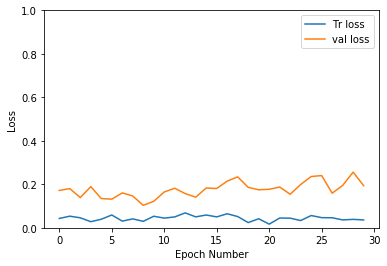

In [68]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr loss', 'val loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

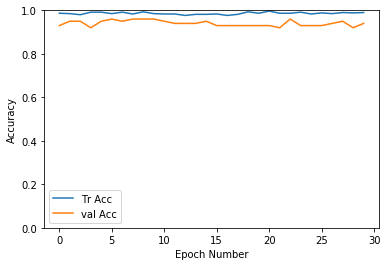

In [69]:
plt.plot(history[:,2:4])
plt.legend(['Tr Acc', 'val Acc'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_acc_curve.png')
plt.show()

In [0]:
def computeTestSetAccuracy(model, loss_criterion):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  test_acc = 0.0
  test_loss = 0.0

  with torch.no_grad():

    model.eval()

    for j, (inputs, labels) in enumerate(test_data):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      loss = loss_criterion(outputs, labels)

      test_loss += loss.item() * inputs.size(0)

      ret, predictions = torch.max(outputs.data,1)
      correct_counts = predictions.eq(labels.data.view_as(predictions))

      acc = torch.mean(correct_counts.type(torch.FloatTensor))

      test_acc += acc.item() * inputs.size(0)

      print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))

In [0]:
def predict(model, test_image_name):
  transform = image_transforms['test']

  test_image = Image.open(test_image_name)
  plt.imshow(test_image)

  test_image_tensor = transform(test_image)

  if torch.cuda.is_available():
    test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
  else:
    test_image_tensor = test_image_tensor.view(1, 3, 224, 224)

  with torch.no_grad():
    model.eval()

    out = model(test_image_tensor)
    ps = torch.exp(out)
    topk, topclass = ps.topk(3, dim=1)
    for i in range(3):
      print("Predcition", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])

Predcition 1 : chimp , Score:  0.99562556
Predcition 2 : gorilla , Score:  0.0030460139
Predcition 3 : bear , Score:  0.0011417182


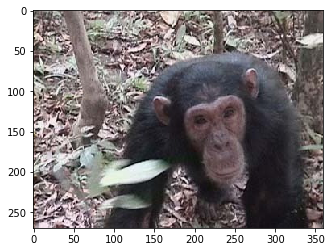

In [78]:
dataset = '/content/gdrive/My Drive/caltech/'
model = torch.load('/content/gdrive/My Drive/caltech/_model_8.pt')
predict(model, '/content/gdrive/My Drive/caltech/test/chimp/038_0071.jpg')

In [82]:
computeTestSetAccuracy(model, loss_func)

Test Batch number: 000, Test: Loss: 0.2881, Accuracy: 0.9062
Test Batch number: 001, Test: Loss: 0.2940, Accuracy: 0.9062
Test Batch number: 002, Test: Loss: 0.0425, Accuracy: 1.0000
Test Batch number: 003, Test: Loss: 0.0756, Accuracy: 0.9688
Test Batch number: 004, Test: Loss: 0.1051, Accuracy: 0.9688
Test Batch number: 005, Test: Loss: 0.1526, Accuracy: 0.9688
Test Batch number: 006, Test: Loss: 0.0208, Accuracy: 1.0000
Test Batch number: 007, Test: Loss: 0.1847, Accuracy: 0.9062
Test Batch number: 008, Test: Loss: 0.2755, Accuracy: 0.9375
Test Batch number: 009, Test: Loss: 0.1264, Accuracy: 0.9688
Test Batch number: 010, Test: Loss: 0.3943, Accuracy: 0.8750
Test Batch number: 011, Test: Loss: 0.1775, Accuracy: 0.9688
Test Batch number: 012, Test: Loss: 0.3051, Accuracy: 0.9200
Test accuracy : 0.9462102699687837
